In [1]:
import os
import torch
import random
import numpy as np
from tqdm.auto import tqdm
import networkx as nx
from torch_geometric.data import Data
from torch_geometric import datasets
from torch_geometric.utils import to_networkx
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from ogb.graphproppred import PygGraphPropPredDataset
import pytorch_lightning as pl
import multiprocessing as mp

In [2]:
class RWDataset(pl.LightningDataModule):
    def __init__(self, name='realworld_gt5.pt'):
        super().__init__()
        self.graphs = None
        self.collected_path = '../data/Realworld/'+name
        self.query_graphs_le5 = [nx.graph_atlas(index) for index in [6, 7] + list(range(13, 19)) + list(range(29, 32)) + list(range(34, 39)) + list(range(40, 53))]

    def sample_data(self, num_each_size=20, max_size=1000):
        # list and download all datasets manually
        # ['dblp_ct1', 'dblp_ct2', 'DBLP_v1', 'facebook_ct1', 'facebook_ct2', 'highschool_ct1', 'highschool_ct2', 'infectious_ct1', 'infectious_ct2', 'mit_ct1', 'mit_ct2', 'tumblr_ct1', 'tumblr_ct2'] in 'social networks' cannot be processed
        tudataset = {
            'molecules': ['AIDS', 'alchemy_full', 'aspirin', 'benzene', 'BZR', 'BZR_MD', 'COX2', 'COX2_MD', 'DHFR', 'DHFR_MD',
                          'ER_MD', 'ethanol', 'FRANKENSTEIN', 'malonaldehyde', 'MCF-7', 'MCF-7H', 'MOLT-4', 'MOLT-4H',
                          'Mutagenicity', 'MUTAG', 'naphthalene', 'NCI1', 'NCI109', 'NCI-H23', 'NCI-H23H', 'OVCAR-8',
                          'OVCAR-8H', 'P388', 'P388H', 'PC-3', 'PC-3H', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR', 'QM9',
                          'salicylic_acid', 'SF-295', 'SF-295H', 'SN12C', 'SN12CH', 'SW-620', 'SW-620H', 'toluene',
                          'Tox21_AhR_training', 'Tox21_AhR_testing', 'Tox21_AhR_evaluation', 'Tox21_AR_training',
                          'Tox21_AR_testing', 'Tox21_AR_evaluation', 'Tox21_AR-LBD_training', 'Tox21_AR-LBD_testing',
                          'Tox21_AR-LBD_evaluation', 'Tox21_ARE_training', 'Tox21_ARE_testing', 'Tox21_ARE_evaluation',
                          'Tox21_aromatase_training', 'Tox21_aromatase_testing', 'Tox21_aromatase_evaluation',
                          'Tox21_ATAD5_training', 'Tox21_ATAD5_testing', 'Tox21_ATAD5_evaluation', 'Tox21_ER_training',
                          'Tox21_ER_testing', 'Tox21_ER_evaluation', 'Tox21_ER-LBD_training', 'Tox21_ER-LBD_testing',
                          'Tox21_ER-LBD_evaluation', 'Tox21_HSE_training', 'Tox21_HSE_testing', 'Tox21_HSE_evaluation',
                          'Tox21_MMP_training', 'Tox21_MMP_testing', 'Tox21_MMP_evaluation', 'Tox21_p53_training',
                          'Tox21_p53_testing', 'Tox21_p53_evaluation', 'Tox21_PPAR-gamma_training', 'Tox21_PPAR-gamma_testing',
                          'Tox21_PPAR-gamma_evaluation', 'UACC257', 'UACC257H', 'uracil', 'Yeast', 'YeastH', 'ZINC_full'],
            'bioinformatics': ['DD', 'ENZYMES', 'KKI', 'OHSU', 'Peking_1', 'PROTEINS'],
            'computer vision': ['COIL-DEL', 'COIL-RAG', 'Cuneiform', 'Fingerprint', 'FIRSTMM_DB', 'Letter-high', 'Letter-low',
                                'Letter-med', 'MSRC_9', 'MSRC_21', 'MSRC_21C'],
            'social networks': ['COLLAB', 'deezer_ego_nets', 'github_stargazers', 'IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY',
                                'REDDIT-MULTI-5K', 'REDDIT-MULTI-12K', 'reddit_threads', 'twitch_egos',
                                'TWITTER-Real-Graph-Partial'],
            'synthetic': ['COLORS-3', 'SYNTHETICnew', 'Synthie', 'TRIANGLES']}
        planetoid = ['Cora', 'CiteSeer', 'PubMed']
        ogb = ['ogbg-molhiv', 'ogbg-molpcba', 'ogbg-ppa']
        
        graph_size = []
        for name in tudataset['molecules']:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        for name in ogb[:2]:
            dataset = PygGraphPropPredDataset(name=name, root='data/OGB')
            for graph in (tqdm(dataset)):
                graph_size.append(graph.num_nodes)
        
        for name in tudataset['bioinformatics']:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        dataset = PygGraphPropPredDataset(name=ogb[2], root='data/OGB')
        for graph in tqdm(dataset):
            graph_size.append(graph.num_nodes)
        
        for name in ['FIRSTMM_DB', 'MSRC_9', 'MSRC_21', 'MSRC_21C']:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        
        for name in tudataset['social networks'][:-1]:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        
        for name in planetoid:
            dataset = datasets.Planetoid(root='data/Planetoid', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
                
        # compute the number of graphs for each node size
        graph_size_count = [0] * max(graph_size)
        for size in graph_size:
            if size > 0:
                graph_size_count[size - 1] += 1
        
        sample_p = [0] * (max_size + 1)
        for i in range(max_size):
            if graph_size_count[i] > 0:
                sample_p[i + 1] = min(num_each_size * 5 / graph_size_count[i], 1)
        
        graphs_selected = [[] for _ in range(max_size + 1)]
        for name in tudataset['molecules']:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    # push the graph to the list with probability sample_p[graph.num_nodes]
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'molecules'))
        for name in ogb[:2]:
            dataset = PygGraphPropPredDataset(name=name, root='data/OGB')
            for graph in (tqdm(dataset)):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'molecules'))
        
        for name in tudataset['bioinformatics']:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'bioinformatics'))
        dataset = PygGraphPropPredDataset(name=ogb[2], root='data/OGB')
        for graph in tqdm(dataset):
            if 0 < graph.num_nodes <= max_size:
                if torch.rand(1).item() < sample_p[graph.num_nodes]:
                    graphs_selected[graph.num_nodes].append((graph, 'bioinformatics'))
        
        for name in ['FIRSTMM_DB', 'MSRC_9', 'MSRC_21', 'MSRC_21C']:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'computer vision'))
        
        for name in tudataset['social networks'][:-1]:
            dataset = datasets.TUDataset(root='data/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'social networks'))
        
        for name in planetoid:
            dataset = datasets.Planetoid(root='data/Planetoid', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'citation networks'))
        
        graphs_selected_copy = graphs_selected.copy()
        for i in range(1, max_size + 1):
            if len(graphs_selected_copy[i]) > num_each_size:
                # randomly select 20 graphs for each size i
                graphs_selected_copy[i] = [graphs_selected_copy[i][j] for j in
                                           torch.randperm(len(graphs_selected_copy[i]))[:num_each_size]]
        
        # draw the graph for number of graph of each size
        fig, axs = plt.subplots(1, 1)
        axs.bar(range(0, max_size+1), [len(graphs_selected_copy[i]) for i in range(max_size+1)])
        # convert the graphs to torch_geometric.data.Data object
        graphs_nx = [to_networkx(d[0], to_undirected=True) for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        graphs_pyg = [from_networkx(g.subgraph(max(nx.connected_components(g), key=len))) for g in graphs_nx]
        domains = [d[1] for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        for i, g in enumerate(graphs_pyg):
            g.domain = domains[i]
        # remove all the graphs with 0 edge
        graphs_pyg = [g for g in graphs_pyg if g.num_edges > 0]
        # keep only 1 graph with num_nodes=2 and num_edges=1
        graphs_pyg = graphs_pyg[:1] + [g for g in graphs_pyg[1:] if not (g.num_nodes == 2 and g.num_edges == 2)]
        
        # save the graphs to file
        torch.save(graphs_pyg, 'data/Realworld/realworld.pt')

    def visualize_graphs(self):
        if self.graphs is None:
            if not os.path.exists(self.collected_path):
                print('Sample data not found, start sampling data')
                self.sample_data()
            self.graphs = torch.load(self.collected_path)
            print('Data loaded, total number of graphs: ', len(self.graphs))
        
        # features of the graphs: (#node, #edge, domain) as key, #that graph as value
        features = {}
        for g in self.graphs:
            key = (g.num_nodes, g.num_edges, g.domain)
            if key in features:
                features[key] += 1
            else:
                features[key] = 1
        # convert the features to list
        features_list = [(key[0], key[1], key[2], value) for key, value in features.items()]
    
        domains = ['molecules', 'bioinformatics', 'computer vision', 'social networks']
        # set different shapes for different domains
        shapes = ['o', '*', 'D', 's']
        # use colormap 'Set3' to represent the domain
        # cmap = plt.colormaps['Set1']
        cmap = ['red', 'green', 'blue', 'purple']
        size_times = [0.5, 50, 50, 2]
    
        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        for index, domain in enumerate(domains):
            x = [f[0] for f in features_list if f[2] == domain]
            y = [f[1] for f in features_list if f[2] == domain]
            s = [size_times[index]*f[3]**2 for f in features_list if f[2] == domain]
            axs[index].scatter(x, y, marker=shapes[index], label=domain, color=cmap[index], s=s, alpha=0.3)
            axs[index].legend()
        # set the x-axis and y-axis labels for the whole figure
        fig.text(0.5, 0.01, 'num_nodes', ha='center')
        fig.text(0.1, 0.5, 'num_edges', va='center', rotation='vertical')
    
        features_list_no_count = []
        for key, value in features.items():
            for _ in range(value):
                features_list_no_count.append(key)
        color_scheme2 = ['red', 'green', 'blue', 'purple']
        fig, axs = plt.subplots(1, 1, figsize=(12, 4))
        for index, domain in enumerate(domains):
            x = [f[0] for f in features_list_no_count if f[2] == domain]
            y = [f[1] for f in features_list_no_count if f[2] == domain]
            axs.scatter(x, y, marker=shapes[index], label=domain, color=color_scheme2[index], s=0.55, alpha=0.5)
            axs.legend()
        # set the x-axis and y-axis labels for the whole figure
        fig.text(0.5, 0.01, 'num_nodes', ha='center')
        fig.text(0.06, 0.5, 'num_edges', va='center', rotation='vertical')
    
        # draw the dot plot with x-axis=domain, y-axis=num_nodes/num_edges/density of the graphs in graphs_pyg
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        axs[0].scatter([f[2] for f in features_list_no_count], [f[0] for f in features_list_no_count], s=0.1, alpha=0.8)
        axs[0].set_ylabel('num_nodes')
        axs[0].set_xlabel('domain')
        axs[1].scatter([f[2] for f in features_list_no_count], [f[1] for f in features_list_no_count], s=0.1, alpha=0.8)
        axs[1].set_ylabel('num_edges')
        axs[1].set_xlabel('domain')
        axs[2].scatter([f[2] for f in features_list_no_count], [f[1]/f[0] for f in features_list_no_count], s=0.1, alpha=0.8)
        axs[2].set_ylabel('density')
        axs[2].set_xlabel('domain')
    
        # draw the graph to show the distribution of the graph node size, edge size, and density
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        node_size_distribution = [0 for _ in range(1001)]
        edge_size_distribution = {}
        density_distribution = {}
        for f in features_list:
            node_size_distribution[f[0]] += f[3]
            if f[1] in edge_size_distribution:
                edge_size_distribution[f[1]] += f[3]
            else:
                edge_size_distribution[f[1]] = f[3]
            density = f[1] // f[0]
            if density in density_distribution:
                density_distribution[density] += f[3]
            else:
                density_distribution[density] = f[3]
    
        axs[0].hist([x[0] for x in features_list_no_count], bins=10, linewidth=0.5, edgecolor='black')
        axs[0].set_xlabel('num_nodes')
        axs[0].set_ylabel('count')
        # set the x-axis as log scale
        axs[1].hist([x[1]//2 for x in features_list_no_count], bins=100, linewidth=0.5, edgecolor='black')
        # axs[1].set_xscale('log')
        axs[1].set_xlabel('num_edges')
        axs[1].set_ylabel('count')
        # set the x-axis and y-axis as log scale
        axs[2].hist([x[1]//2/x[0] for x in features_list_no_count], bins=50, linewidth=0.5, edgecolor='black')
        # axs[2].set_xscale('log')
        # axs[2].set_yscale('log')
        axs[2].set_xlabel('density')
        axs[2].set_ylabel('count')
        
        # node-layer features
        pattern_dis_induced = torch.cat([g.gt_induced_le5.T for g in self.graphs], dim=1)
        print('pattern_dis_induced shape: ', pattern_dis_induced.shape)
        # bins_pattern = [max(pattern_dis_induced[i].tolist()) // 10 for i in range(30)]
        # print('bins_pattern: ', bins_pattern)
        fig, axs = plt.subplots(5, 6, figsize=(24, 20))
        for i, ax in enumerate(axs.flatten()):
            ax.hist(pattern_dis_induced[i].numpy(), bins=10, linewidth=0.5, edgecolor='black')
            ax.set_yscale('log')
            ax.set_title(f'pattern {i}')
        
    def setup(self, stage=None, method='orca'):
        if not os.path.exists(self.collected_path):
            print('Sample data not found, start sampling data')
            self.sample_data()
        self.graphs = torch.load(self.collected_path)
        print('Data loaded, total number of graphs: ', len(self.graphs))

        if method == 'orca':
            # convert the graphs to edgelist format and save to files
            for i, g in tqdm(zip(range(len(self.graphs)), self.graphs), total=len(self.graphs)):
                with open(f'data_split/rw_{i}.edgelist', 'w') as f:
                    f.write(f'{g.num_nodes} {g.num_edges//2}\n')
                    for edge in g.edge_index.T:
                        if edge[0] < edge[1]:
                            f.write(f'{edge[0]} {edge[1]}\n')
                            
            # change the paths to the correct paths in your computer
            # call the orca algorithm to compute the induced subgraph counts
            for i in range(len(self.graphs)):
                os.system(f'C:\\Users\\27491\\Desktop\\Research\\MLSC-CodeLib\\orca\\orca.exe 5 C:\\Users\\27491\\Desktop\\Research\\MLSC-CodeLib\\GroundTruth_MLSC\\realworld\\data_split\\rw_{i}.edgelist C:\\Users\\27491\\Desktop\\Research\\MLSC-CodeLib\\GroundTruth_MLSC\\realworld\\orca_result\\rw_{i}.result')

            # code from 'EVOKE'
            # convert induced counts to non-induced counts
            matrices = dict() # conversion matrices (A): converting induced counts to non-induced counts
            matrices[3] = np.matrix('1 0 2 ;'
                                    '0 1 1 ;'
                                    '0 0 1 ')
            matrices[4] = np.matrix('1 0 0 0 2 2 1 0 4 2 6 ;'
                                    '0 1 0 0 2 0 1 2 2 4 6 ;'
                                    '0 0 1 0 0 1 1 0 2 1 3 ;'
                                    '0 0 0 1 0 0 0 1 0 1 1 ;'
                                    '0 0 0 0 1 0 0 0 1 1 3 ;'
                                    '0 0 0 0 0 1 0 0 2 0 3 ;'
                                    '0 0 0 0 0 0 1 0 2 2 6 ;'
                                    '0 0 0 0 0 0 0 1 0 2 3 ;'
                                    '0 0 0 0 0 0 0 0 1 0 3 ;'
                                    '0 0 0 0 0 0 0 0 0 1 3 ;'
                                    '0 0 0 0 0 0 0 0 0 0 1')
            matrices[5] = np.matrix('1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 2.0 0.0 1.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 1.0 0.0 2.0 1.0 0.0 0.0 2.0 0.0 4.0 2.0 0.0 1.0 4.0 0.0 3.0 4.0 2.0 4.0 0.0 6.0 2.0 0.0 6.0 3.0 2.0 8.0 4.0 6.0 12.0 8.0 4.0 10.0 8.0 18.0 12.0 24.0 ;'
                                    '0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 2.0 0.0 0.0 2.0 2.0 2.0 0.0 0.0 2.0 4.0 1.0 0.0 6.0 3.0 2.0 3.0 0.0 6.0 0.0 2.0 6.0 3.0 5.0 4.0 4.0 8.0 4.0 4.0 6.0 10.0 10.0 8.0 12.0 16.0 24.0 ;'
                                    '0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 2.0 2.0 0.0 1.0 1.0 2.0 2.0 0.0 0.0 2.0 0.0 1.0 2.0 4.0 2.0 2.0 4.0 2.0 4.0 4.0 4.0 8.0 6.0 8.0 12.0 ;'
                                    '0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 0.0 0.0 1.0 1.0 2.0 0.0 1.0 0.0 2.0 2.0 0.0 0.0 0.0 3.0 2.0 0.0 0.0 2.0 3.0 3.0 2.0 0.0 3.0 2.0 0.0 4.0 3.0 0.0 6.0 4.0 3.0 5.0 0.0 9.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 0.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0 1.0 0.0 4.0 3.0 0.0 0.0 2.0 0.0 2.0 2.0 0.0 2.0 4.0 0.0 1.0 4.0 1.0 8.0 0.0 6.0 4.0 0.0 6.0 3.0 2.0 4.0 2.0 6.0 12.0 10.0 4.0 8.0 8.0 18.0 12.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 2.0 1.0 1.0 0.0 0.0 0.0 2.0 1.0 2.0 0.0 1.0 0.0 1.0 2.0 3.0 0.0 2.0 3.0 1.0 3.0 2.0 2.0 2.0 2.0 2.0 4.0 5.0 4.0 4.0 6.0 8.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 1.0 4.0 0.0 4.0 0.0 0.0 2.0 1.0 0.0 3.0 0.0 0.0 2.0 0.0 6.0 0.0 1.0 6.0 0.0 2.0 6.0 0.0 3.0 2.0 0.0 2.0 8.0 3.0 8.0 3.0 10.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 1.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 2.0 2.0 1.0 1.0 0.0 3.0 2.0 4.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 1.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 4.0 0.0 6.0 2.0 0.0 4.0 1.0 0.0 4.0 2.0 0.0 12.0 6.0 2.0 6.0 0.0 18.0 8.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 2.0 0.0 0.0 2.0 0.0 1.0 1.0 1.0 0.0 0.0 2.0 2.0 4.0 2.0 2.0 4.0 6.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 6.0 0.0 2.0 6.0 0.0 3.0 4.0 0.0 2.0 2.0 0.0 4.0 10.0 4.0 8.0 6.0 16.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 2.0 1.0 0.0 4.0 1.0 0.0 6.0 2.0 1.0 4.0 0.0 9.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 1.0 2.0 0.0 2.0 2.0 0.0 2.0 2.0 3.0 4.0 0.0 6.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 0.0 1.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 2.0 0.0 3.0 2.0 2.0 0.0 2.0 4.0 4.0 6.0 4.0 6.0 8.0 12.0 12.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 4.0 0.0 1.0 2.0 0.0 2.0 4.0 2.0 8.0 3.0 8.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.0 0.0 3.0 1.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 6.0 4.0 1.0 2.0 0.0 9.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 3.0 0.0 2.0 0.0 1.0 2.0 0.0 0.0 0.0 0.0 2.0 4.0 3.0 2.0 0.0 6.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 3.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 4.0 0.0 4.0 0.0 5.0 6.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 2.0 4.0 4.0 6.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 0.0 2.0 0.0 3.0 0.0 0.0 2.0 0.0 0.0 2.0 0.0 3.0 6.0 3.0 0.0 3.0 4.0 9.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 3.0 1.0 0.0 0.0 0.0 3.0 0.0 1.0 0.0 1.0 1.0 0.0 2.0 3.0 0.0 2.0 2.0 3.0 4.0 0.0 6.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 4.0 0.0 1.0 0.0 1.0 4.0 0.0 0.0 2.0 0.0 1.0 2.0 2.0 4.0 2.0 4.0 4.0 6.0 4.0 6.0 8.0 12.0 12.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 3.0 0.0 0.0 1.0 0.0 3.0 0.0 0.0 3.0 0.0 1.0 2.0 0.0 3.0 1.0 0.0 1.0 5.0 3.0 4.0 3.0 8.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 3.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 6.0 2.0 0.0 1.0 0.0 9.0 2.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.0 0.0 0.0 2.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 4.0 6.0 2.0 2.0 0.0 12.0 8.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 3.0 1.0 0.0 3.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 3.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 5.0 0.0 4.0 0.0 8.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 2.0 2.0 1.0 2.0 0.0 6.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 2.0 0.0 2.0 3.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 1.0 0.0 0.0 2.0 0.0 0.0 6.0 1.0 0.0 2.0 0.0 9.0 2.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 2.0 2.0 1.0 2.0 0.0 6.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 3.0 2.0 0.0 3.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 1.0 2.0 0.0 0.0 2.0 0.0 4.0 4.0 2.0 8.0 6.0 12.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 1.0 2.0 3.0 2.0 6.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 2.0 4.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 4.0 2.0 0.0 4.0 2.0 2.0 6.0 0.0 12.0 8.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 2.0 2.0 2.0 0.0 2.0 4.0 6.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 2.0 2.0 0.0 2.0 4.0 4.0 8.0 6.0 12.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 3.0 1.0 6.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 4.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 3.0 0.0 4.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 3.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 4.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 4.0 2.0 0.0 2.0 0.0 12.0 4.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 2.0 2.0 0.0 6.0 8.0 24.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 4.0 0.0 6.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 3.0 1.0 6.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 2.0 0.0 3.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 4.0 3.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 3.0 0.0 6.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 3.0 2.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 4.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 3.0 2.0 12.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 3.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 4.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 6.0 ;'
                                    '0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0')
            size_3 = torch.tensor(matrices[3], dtype=torch.int64)
            size_4 = torch.tensor(matrices[4], dtype=torch.int64)
            size_5 = torch.tensor(matrices[5], dtype=torch.int64)

            # read in induced orbit counts and convert to non-induced orbit counts
            for i in range(len(self.graphs)):
                file_path = f'orca_result/rw_{i}.result'
                # read in file as a 2-d list
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    
                    induced_orbit = torch.tensor([[int(x) for x in line.strip().split()] for line in lines], dtype=torch.int64)
                    induced = torch.tensor([[x[0], x[1]+x[2], x[3], x[4]+x[5], x[6]+x[7], x[8], x[9]+x[10]+x[11], x[12]+x[13], x[14], x[15]+x[16]+x[17], x[18]+x[19]+x[20]+x[21], x[22]+x[23], x[24]+x[25]+x[26], x[27]+x[28]+x[29]+x[30], x[31]+x[32]+x[33], x[34], x[35]+x[36]+x[37]+x[38], x[39]+x[40]+x[41]+x[42], x[43]+x[44], x[45]+x[46]+x[47]+x[48], x[49]+x[50], x[51]+x[52]+x[53], x[54]+x[55], x[56]+x[57]+x[58], x[59]+x[60]+x[61], x[62]+x[63]+x[64], x[65]+x[66]+x[67], x[68]+x[69], x[70]+x[71], x[72]] for x in induced_orbit.tolist()])

                    noninduced_orbit = torch.cat([induced_orbit[:, :1].clone(), torch.mm(size_3, induced_orbit[:, 1:4].T).T, torch.mm(size_4, induced_orbit[:, 4:15].T).T, torch.mm(size_5, induced_orbit[:, 15:].T).T], dim=1)
                    noninduced = torch.tensor([[x[0], x[1]+x[2], x[3], x[4]+x[5], x[6]+x[7], x[8], x[9]+x[10]+x[11], x[12]+x[13], x[14], x[15]+x[16]+x[17], x[18]+x[19]+x[20]+x[21], x[22]+x[23], x[24]+x[25]+x[26], x[27]+x[28]+x[29]+x[30], x[31]+x[32]+x[33], x[34], x[35]+x[36]+x[37]+x[38], x[39]+x[40]+x[41]+x[42], x[43]+x[44], x[45]+x[46]+x[47]+x[48], x[49]+x[50], x[51]+x[52]+x[53], x[54]+x[55], x[56]+x[57]+x[58], x[59]+x[60]+x[61], x[62]+x[63]+x[64], x[65]+x[66]+x[67], x[68]+x[69], x[70]+x[71], x[72]] for x in noninduced_orbit.tolist()])
            
                    # assign the tensor to the rw dataset
                    self.graphs[i].gt_induced_le5 = induced
                    self.graphs[i].gt_noninduced_le5 = noninduced
                
        elif method == 'match':
            num_automorphisms = []
            for query_graph_ in self.query_graphs_le5:
                num_automorphism_per = 0
                for _ in nx.algorithms.isomorphism.GraphMatcher(query_graph_, query_graph_).subgraph_isomorphisms_iter():
                    num_automorphism_per += 1
                num_automorphisms.append(num_automorphism_per)
            print("Number of automorphism of query graphs: ", num_automorphisms)
            
            tasks = [(index, g, self.query_graphs_le5, num_automorphisms) for index, g in enumerate(self.graphs)]
            print('Tasks prepared, total number of tasks: ', len(tasks))
            # use multiprocessing to speed up the computation, return can be unordered
            with mp.Pool(mp.cpu_count()//2) as pool:
                indices = pool.imap_unordered(self.induced_count_per_node, tasks)
                for index in indices:
                    print('Finish processing graph ', index)

    # use graph matching to compute the induced count per node
    def induced_count_per_node(self, task):
        print(f"Start processing graph {task[0]}")
        index, data_graph_d, query_graphs, num_automorphisms = task
        data_graph = to_networkx(data_graph_d, to_undirected=True)
        y = [[0] * len(query_graphs) for _ in range(data_graph.number_of_nodes())]
        for i, (query_graph, num_automorphism) in enumerate(zip(query_graphs, num_automorphisms)):
            for subgraph in nx.algorithms.isomorphism.GraphMatcher(data_graph, query_graph).subgraph_isomorphisms_iter():
                for node in subgraph:
                    y[node][i] += 1
        for i in range(data_graph.number_of_nodes()):
            for j in range(len(query_graphs)):
                y[i][j] = y[i][j] / num_automorphisms[j]
        x = torch.ones(data_graph.number_of_nodes(), 1, dtype=torch.float32)
        new_data = Data(x=x, y=y, edge_index=data_graph_d.edge_index, domain=data_graph_d.domain[0])
        
        # save the new_data to file
        torch.save(new_data, f'../data/temp/realworld_{index}.pt')
        # print(f"Finish processing graph {index}")
        return index
    
    def split_dataset(self):
        size_split = {}
        for i, g in enumerate(self.graphs):
            size = min(g.num_nodes // 100, 9)
            if size not in size_split:
                size_split[size] = [i]
            else:
                size_split[size].append(i)
        
        train = []
        val = []
        test = []
        for i in range(10):
            if i in size_split:
                temp = size_split[i]
                random.shuffle(temp)
                # 50% train, 20% val, 30% test
                train += temp[:len(temp)//2]
                val += temp[len(temp)//2:len(temp)//2+len(temp)//5]
                test += temp[len(temp)//2+len(temp)//5:]
        # order the train, val, test
        train.sort()
        val.sort()
        test.sort()
        
        # get the dataset with indices in train, val, test
        train_dataset = [self.graphs[i] for i in train]
        val_dataset = [self.graphs[i] for i in val]
        test_dataset = [self.graphs[i] for i in test]
        
        # save the datasets
        torch.save(train_dataset, '../data/Realworld/realworld_gt5_train.pt')
        torch.save(val_dataset, '../data/Realworld/realworld_gt5_val.pt')
        torch.save(test_dataset, '../data/Realworld/realworld_gt5_test.pt')

Data loaded, total number of graphs:  13665
pattern_dis_induced shape:  torch.Size([30, 5090145])


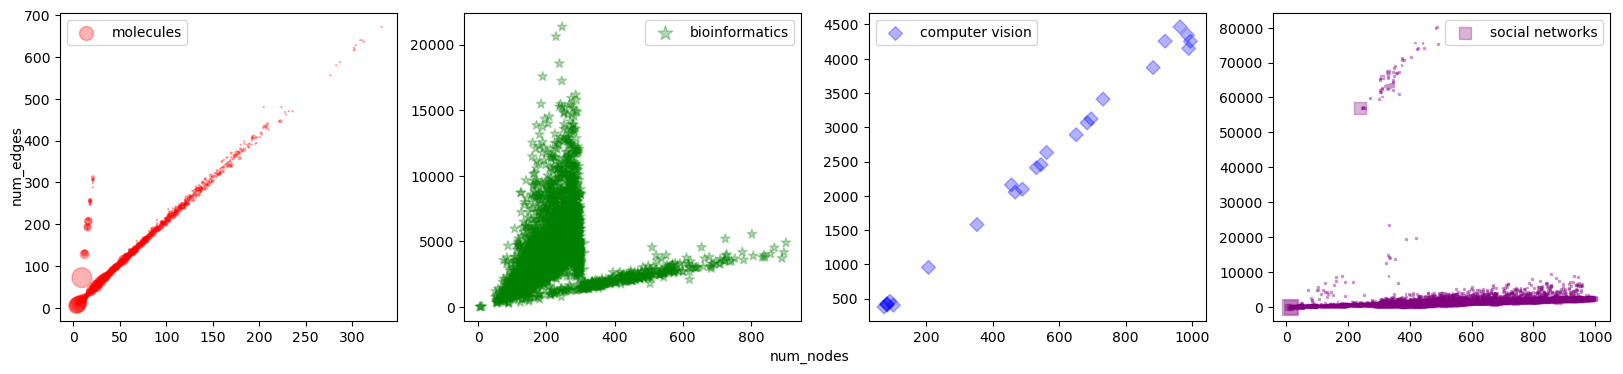

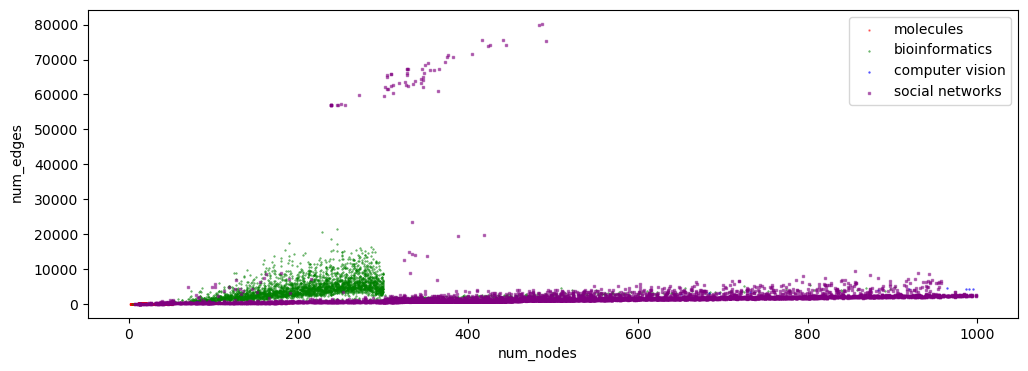

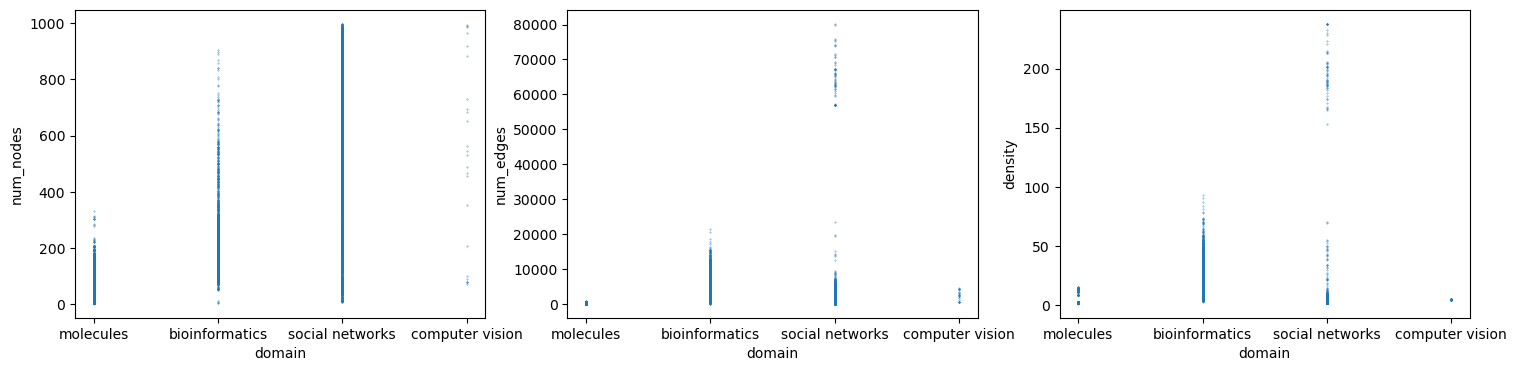

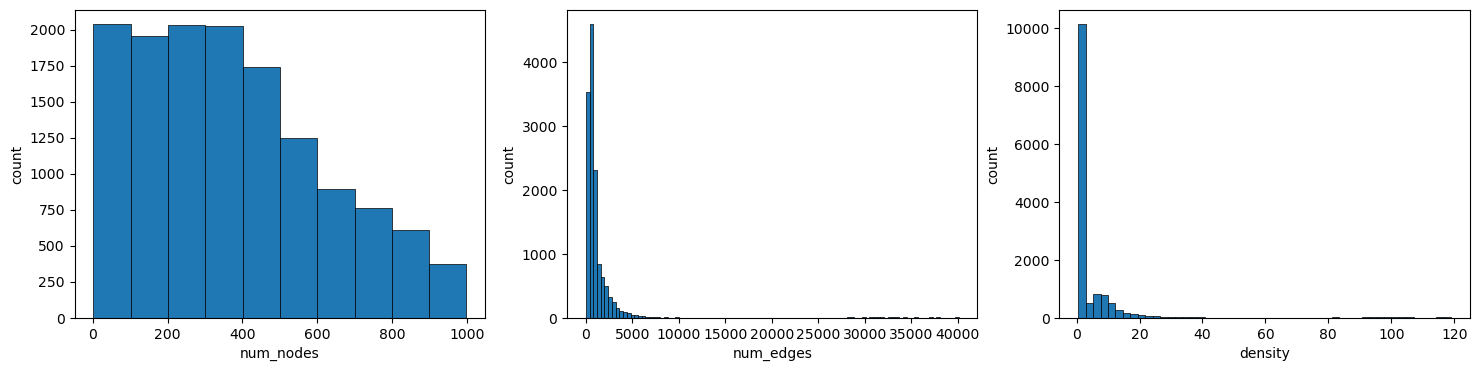

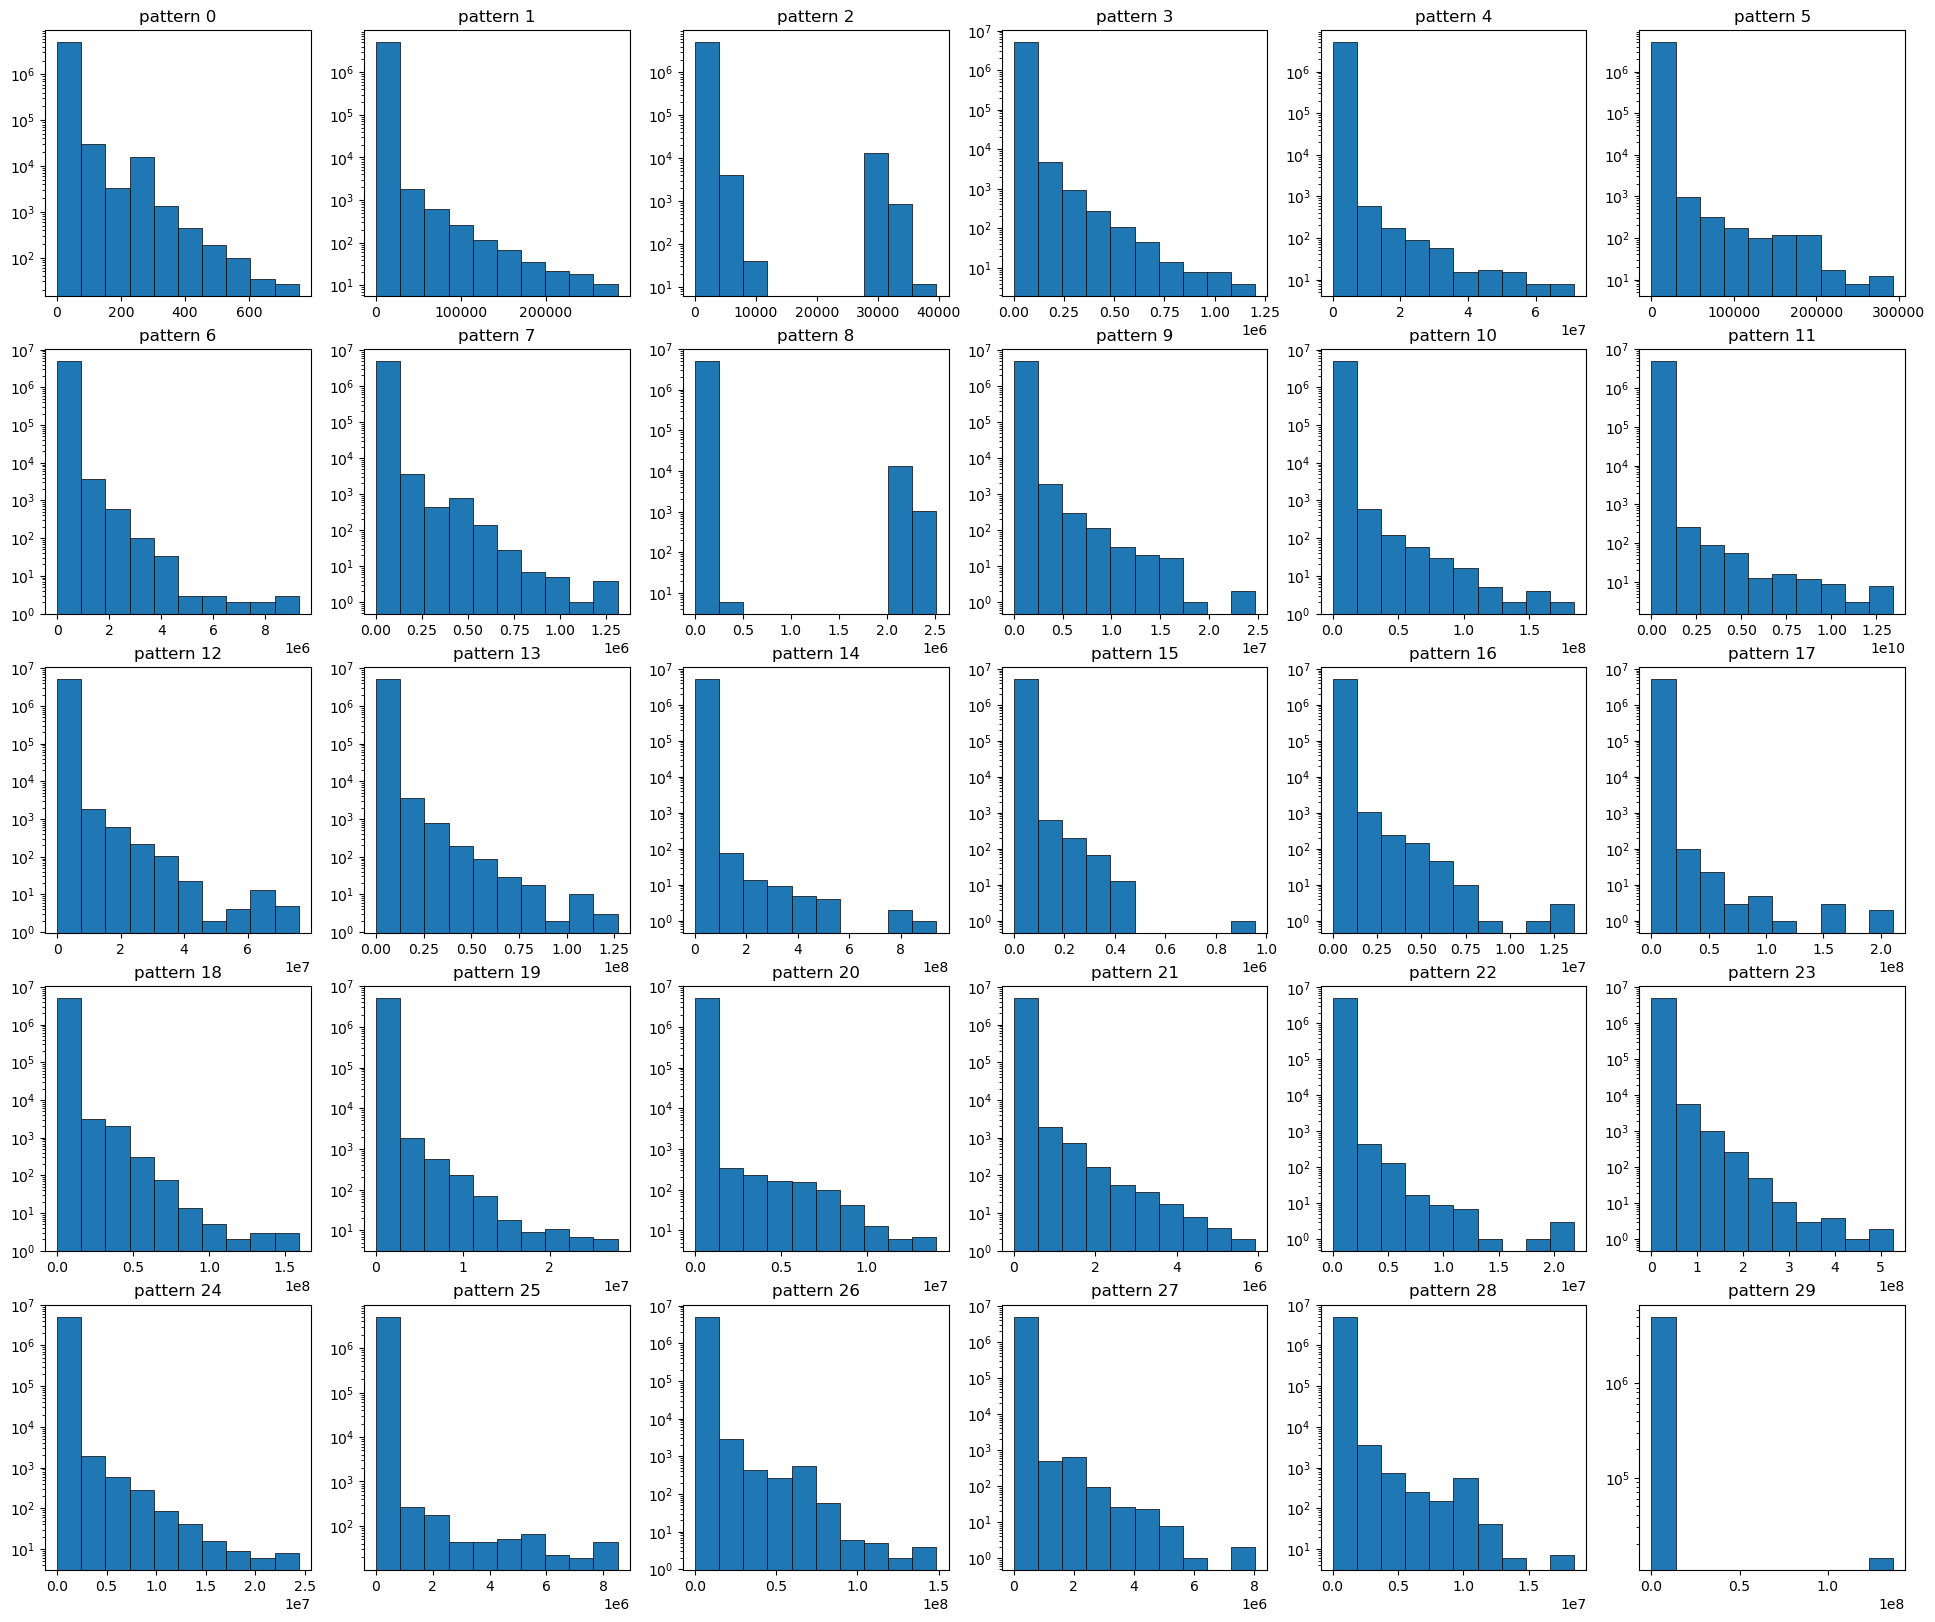

In [8]:
dataset = RWDataset()
# to compute the ground truth, can use SCOPE, EVOKE, JESSE, ORCA, or GRAPH MATCH
# dataset.setup()
dataset.visualize_graphs()

Data loaded, total number of graphs:  6829
pattern_dis_induced shape:  torch.Size([30, 2543901])


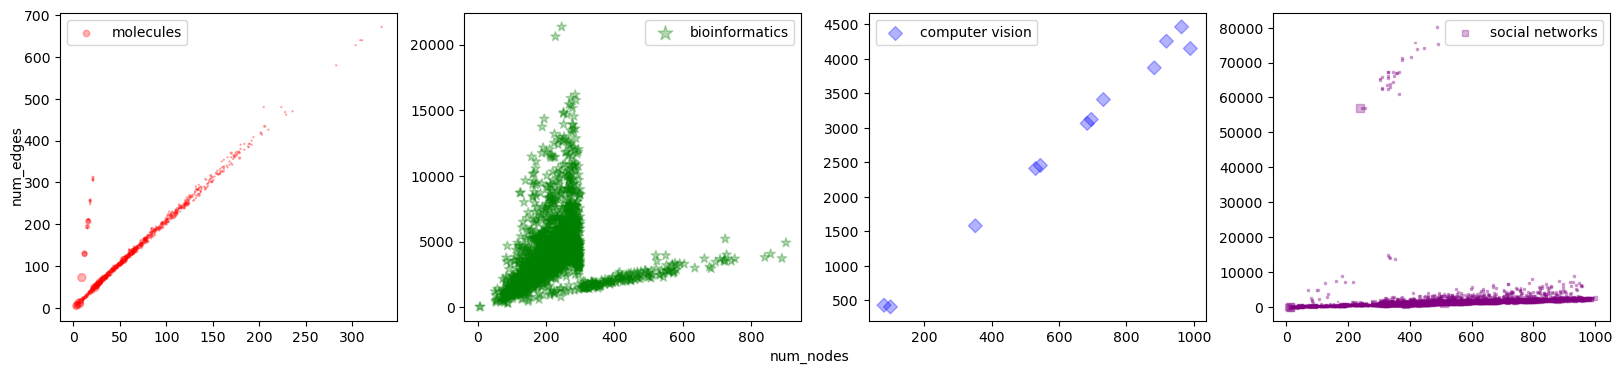

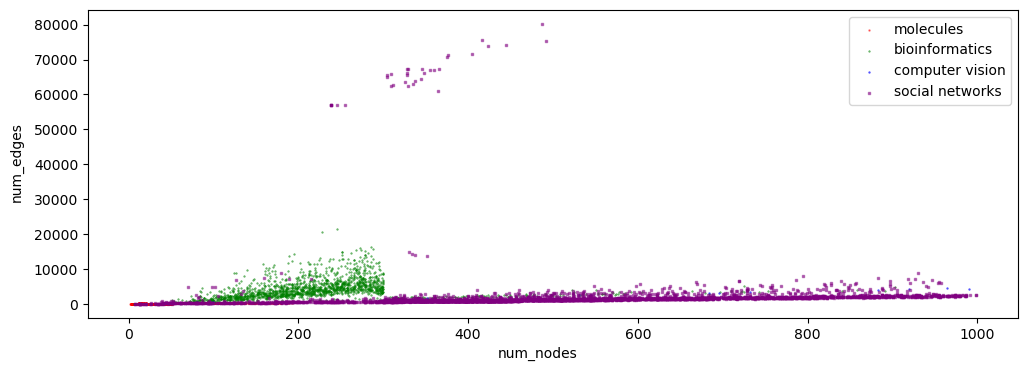

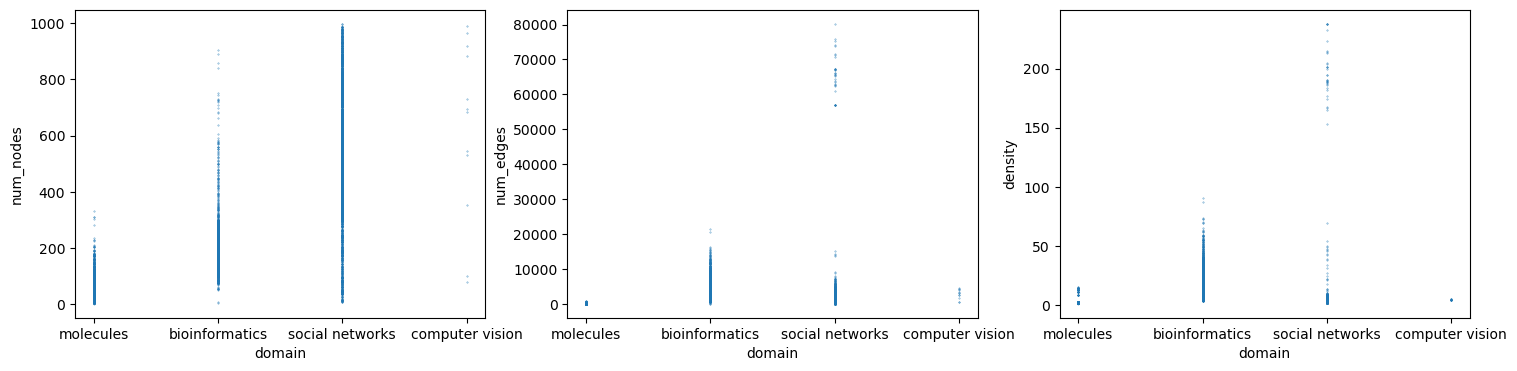

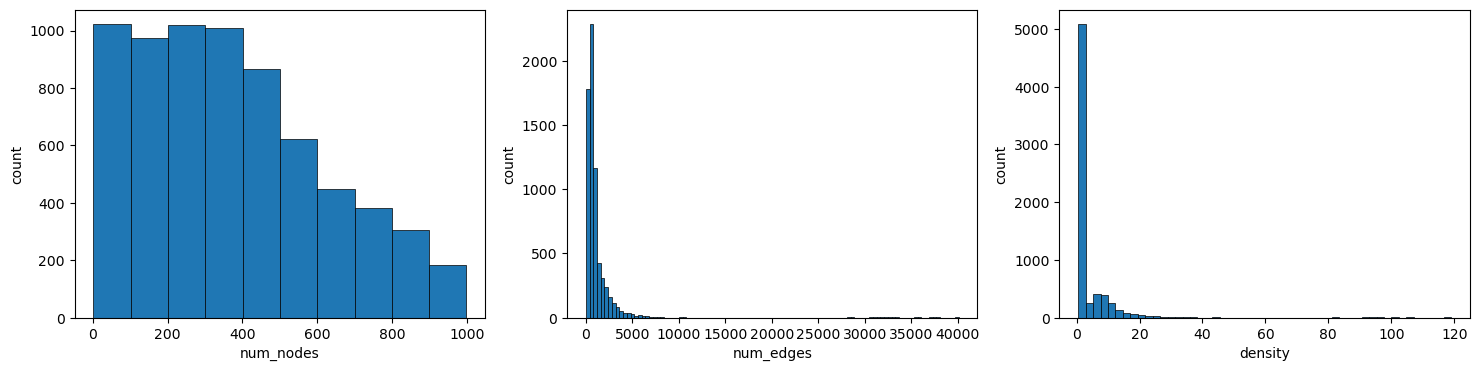

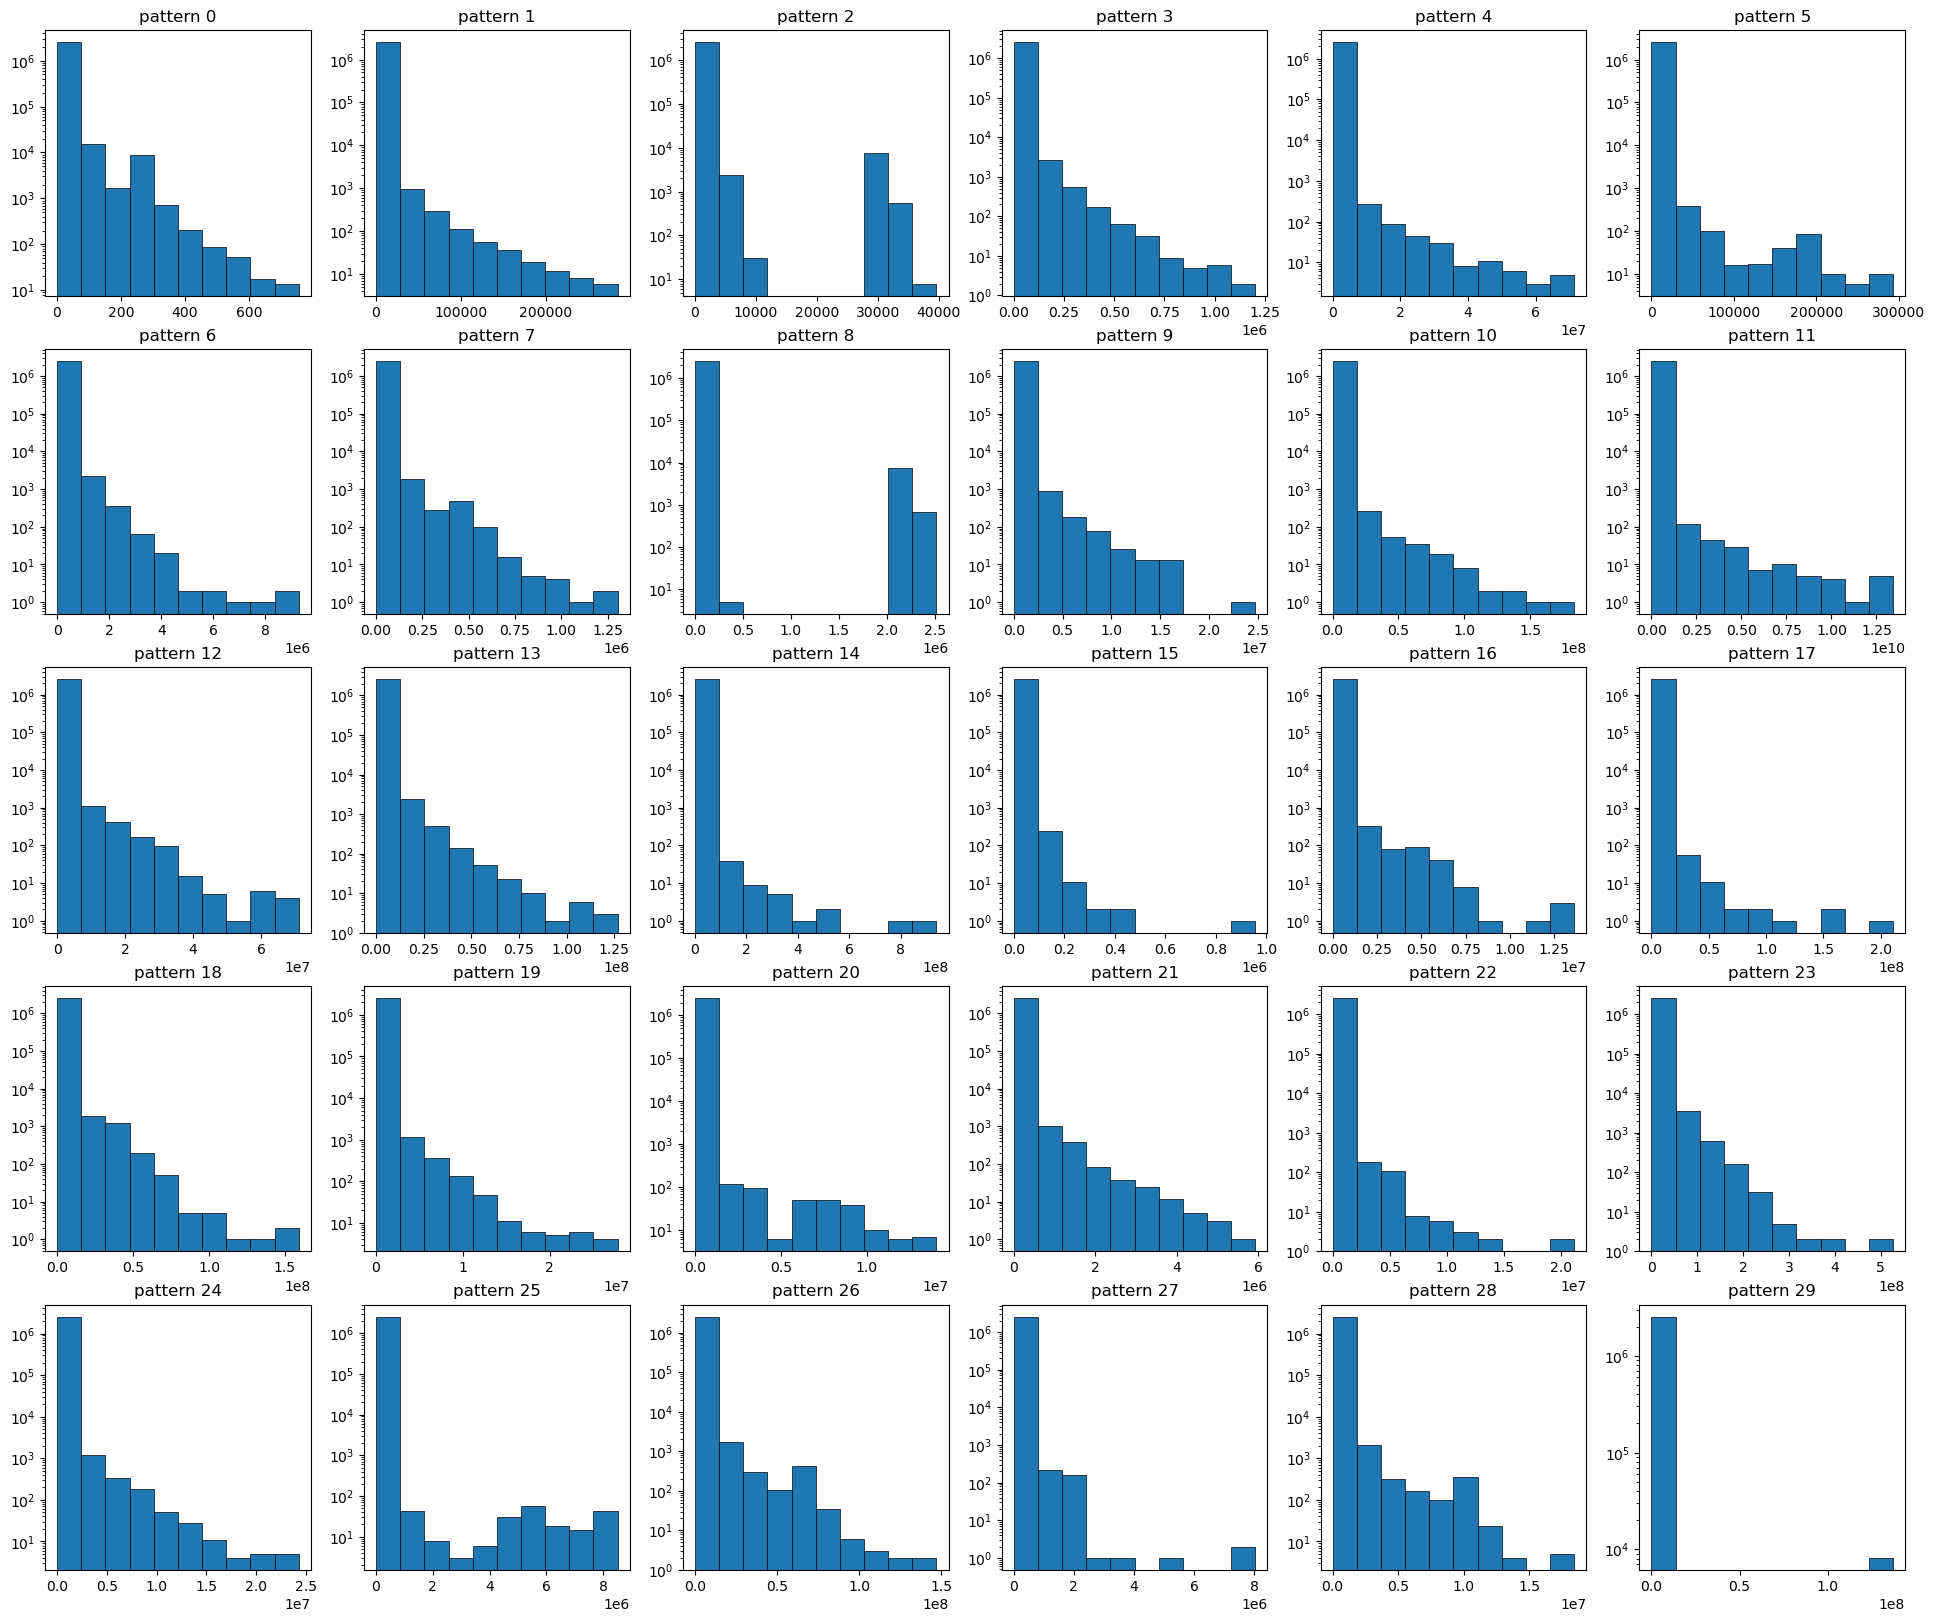

In [3]:
train_dataset = RWDataset('realworld_gt5_train.pt')
train_dataset.visualize_graphs()

Data loaded, total number of graphs:  2729
pattern_dis_induced shape:  torch.Size([30, 1014605])


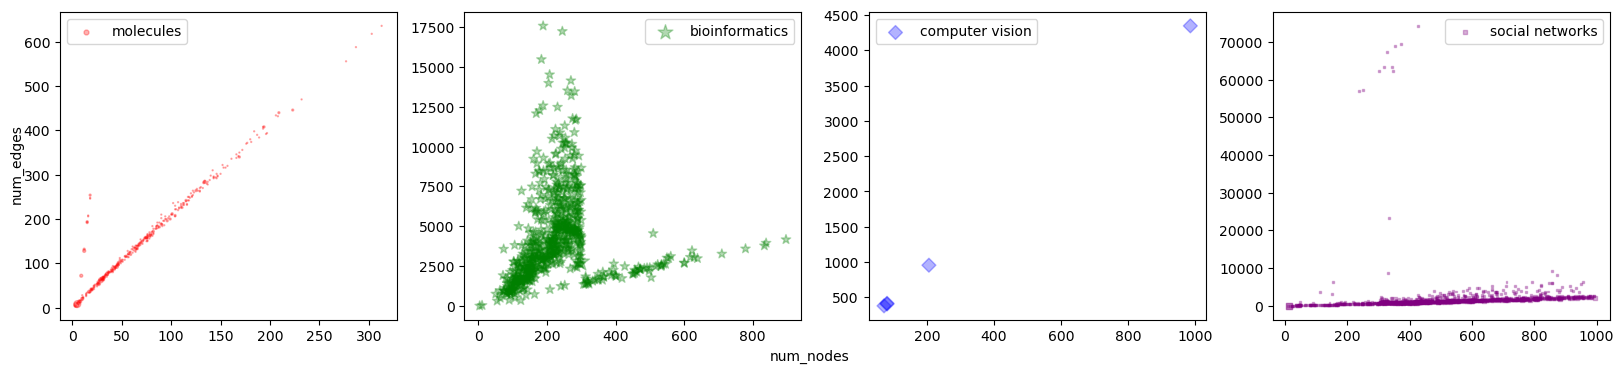

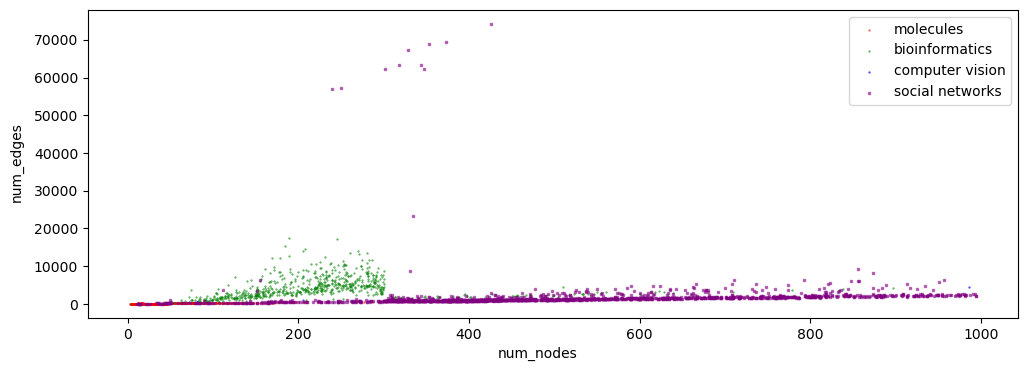

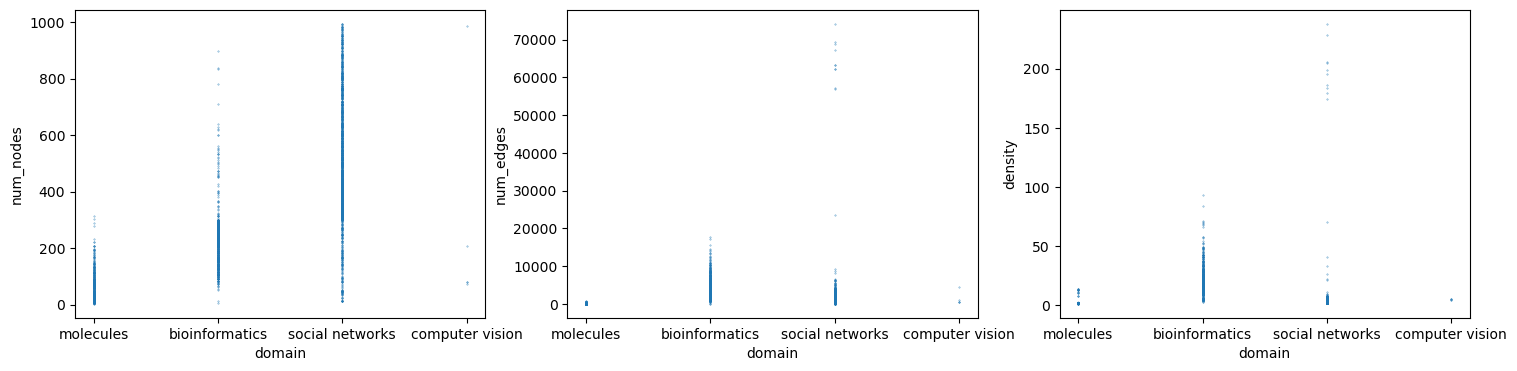

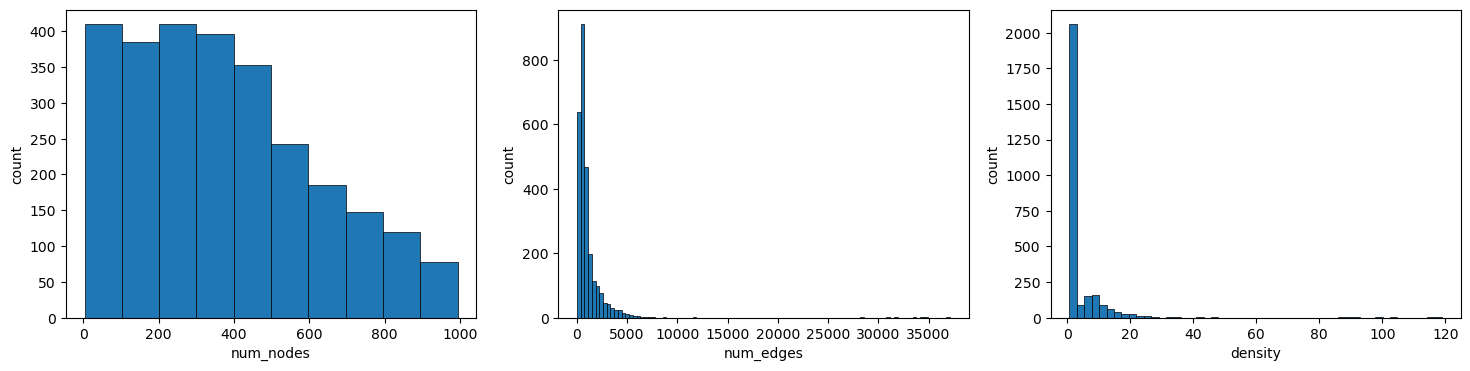

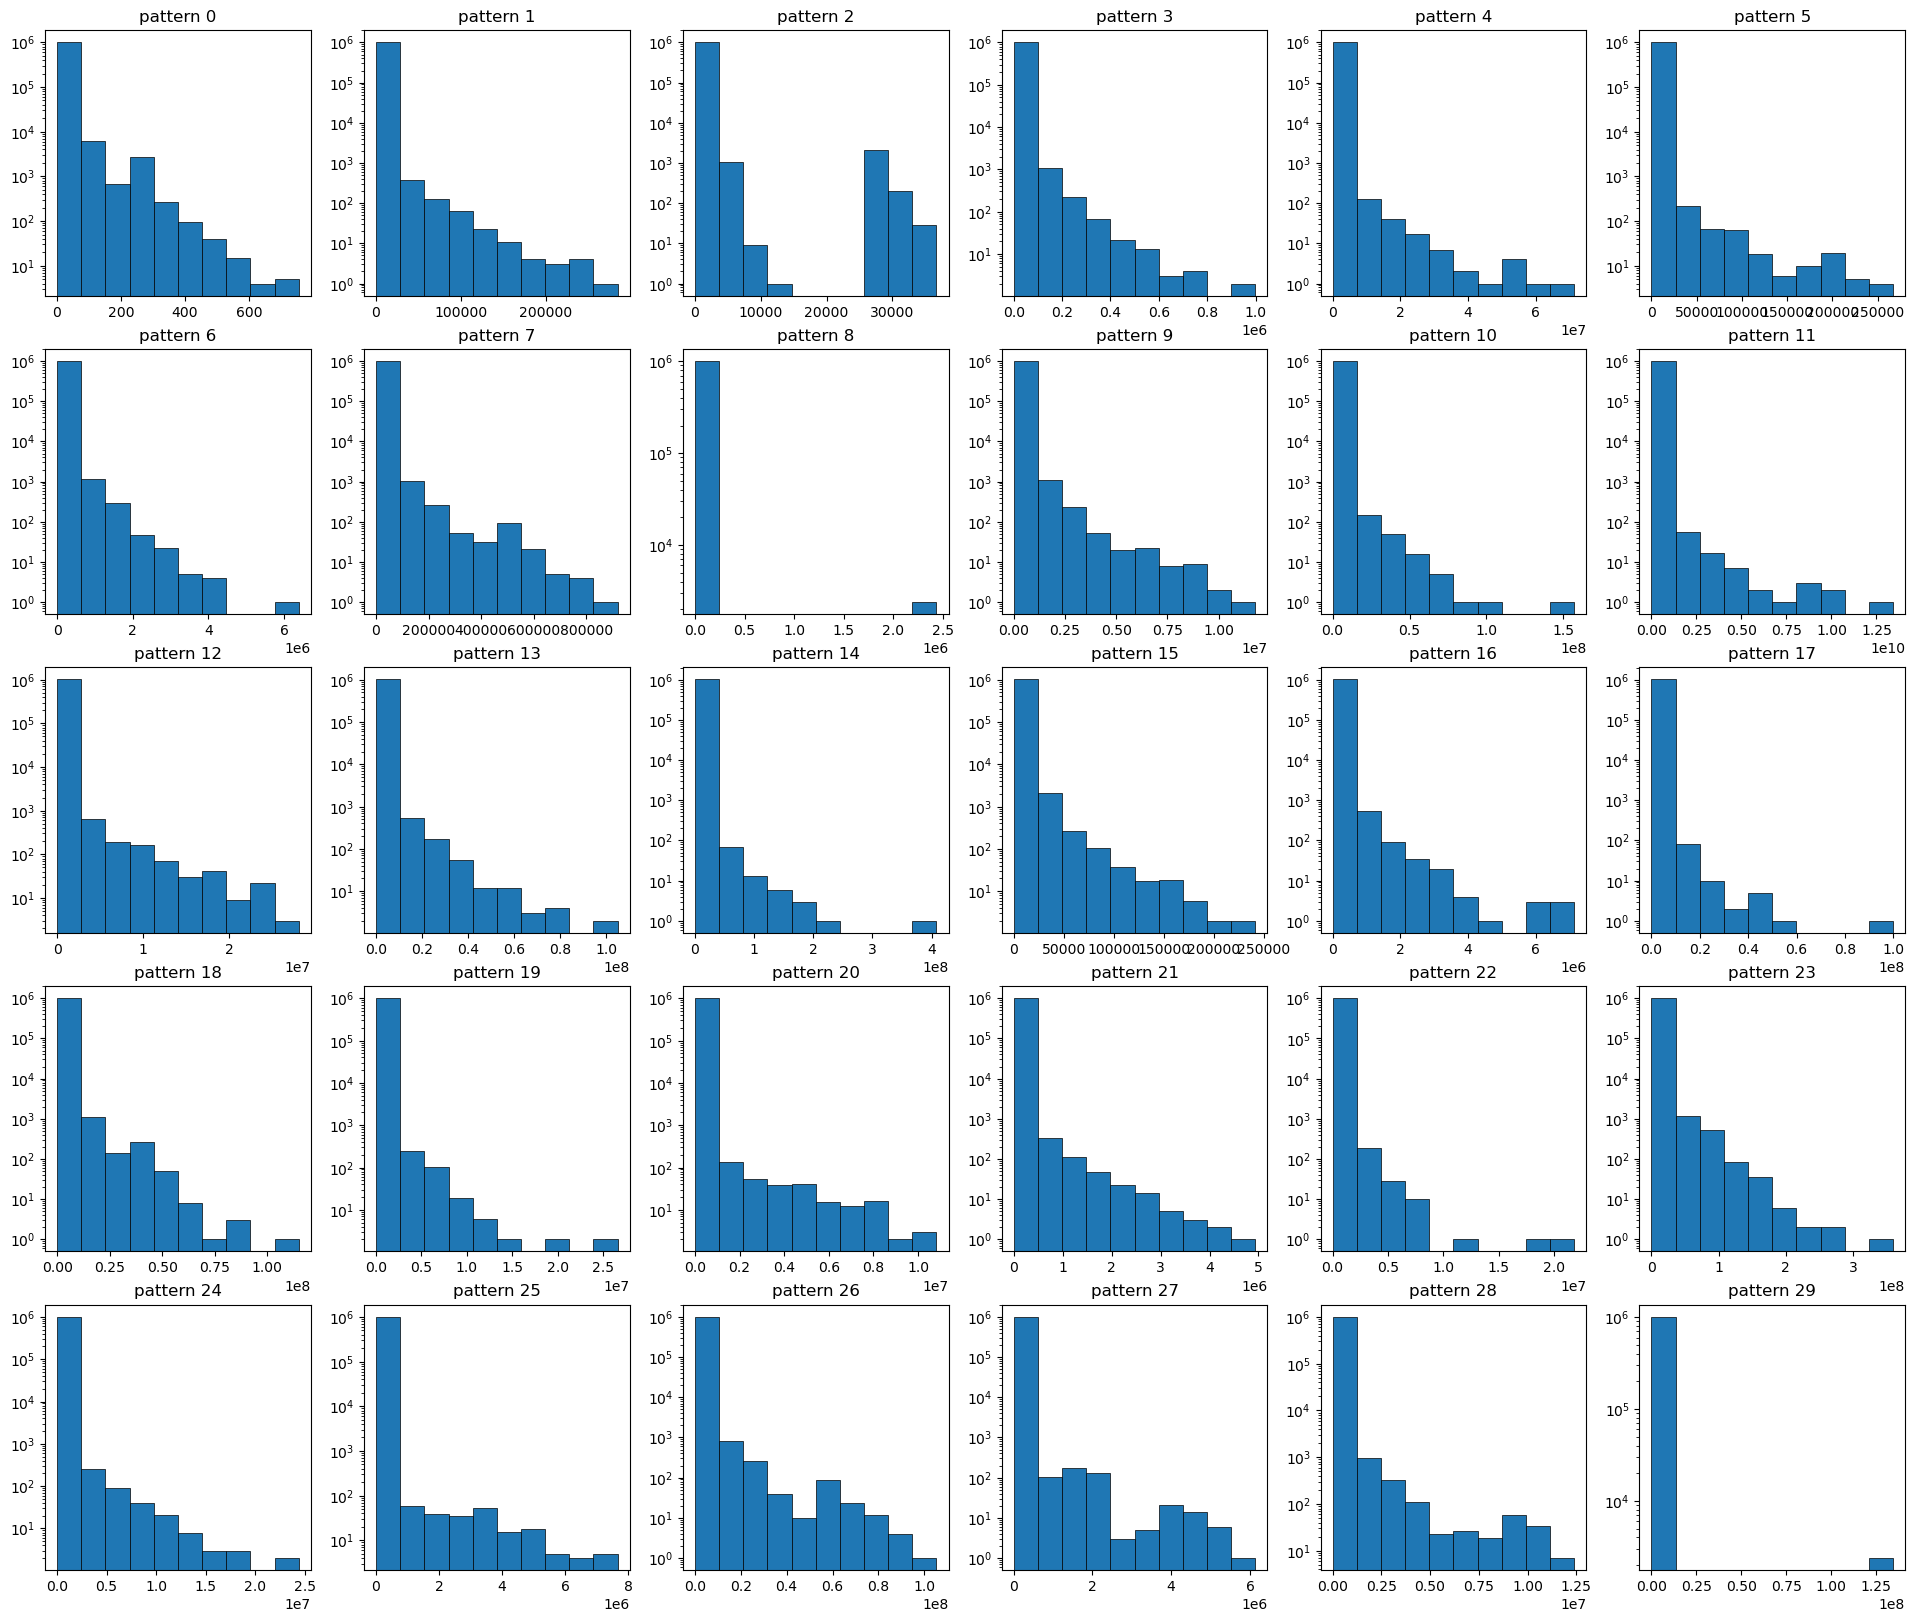

In [4]:
val_dataset = RWDataset('realworld_gt5_val.pt')
val_dataset.visualize_graphs()

Data loaded, total number of graphs:  4107
pattern_dis_induced shape:  torch.Size([30, 1531639])


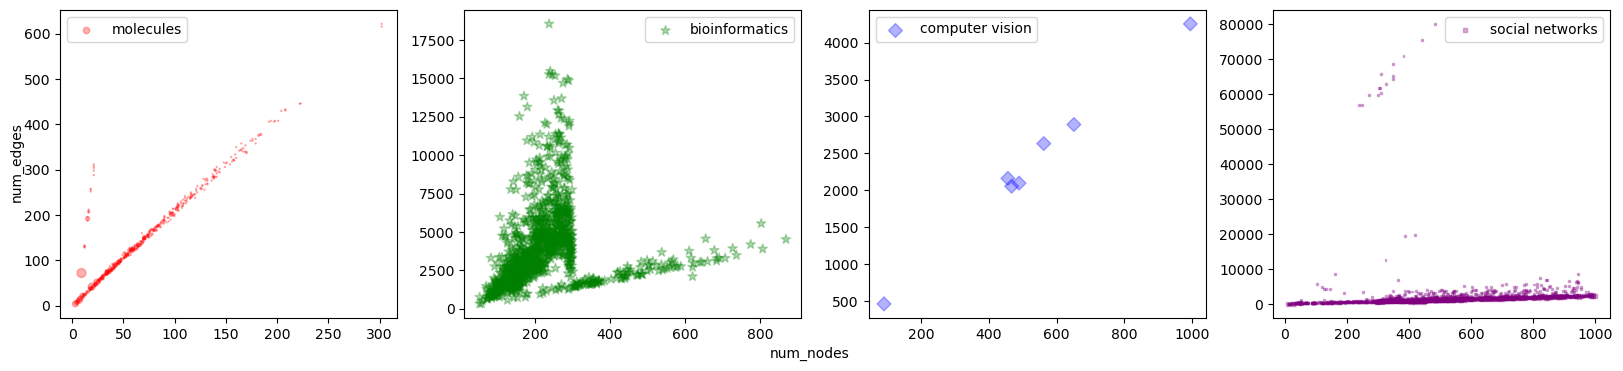

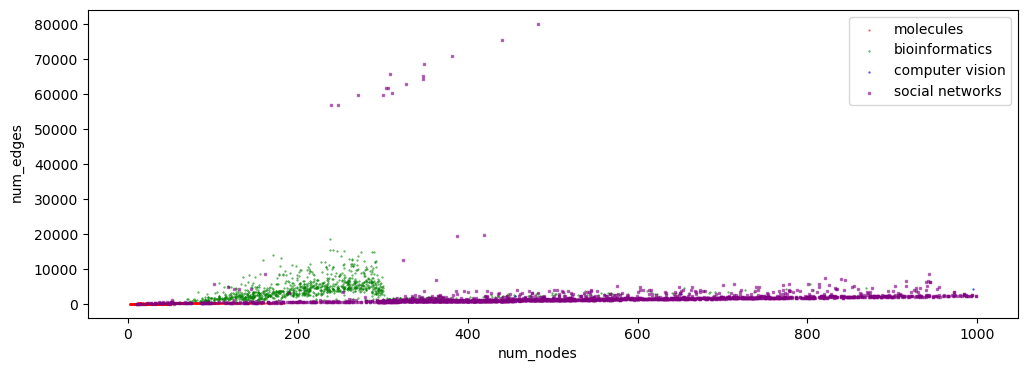

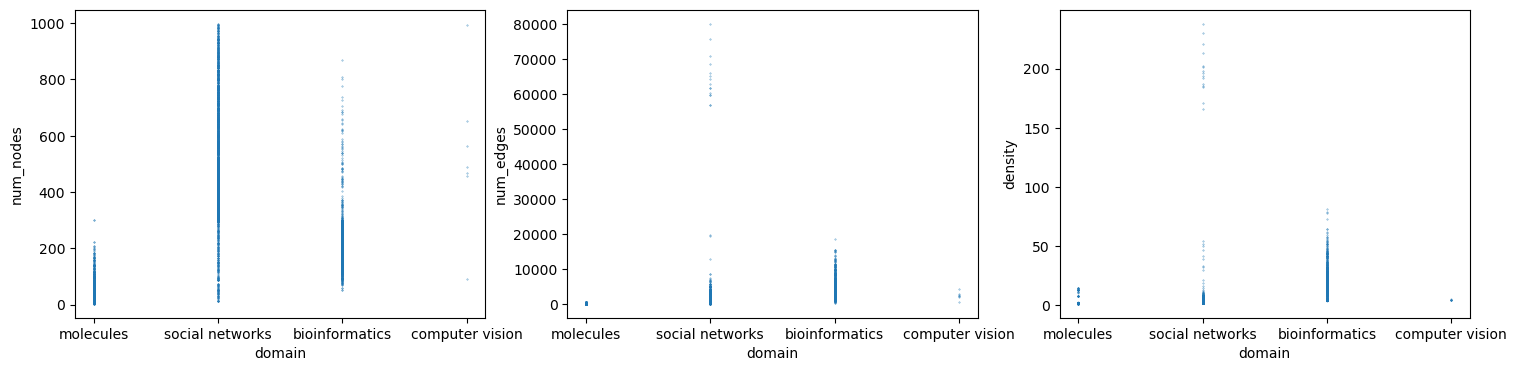

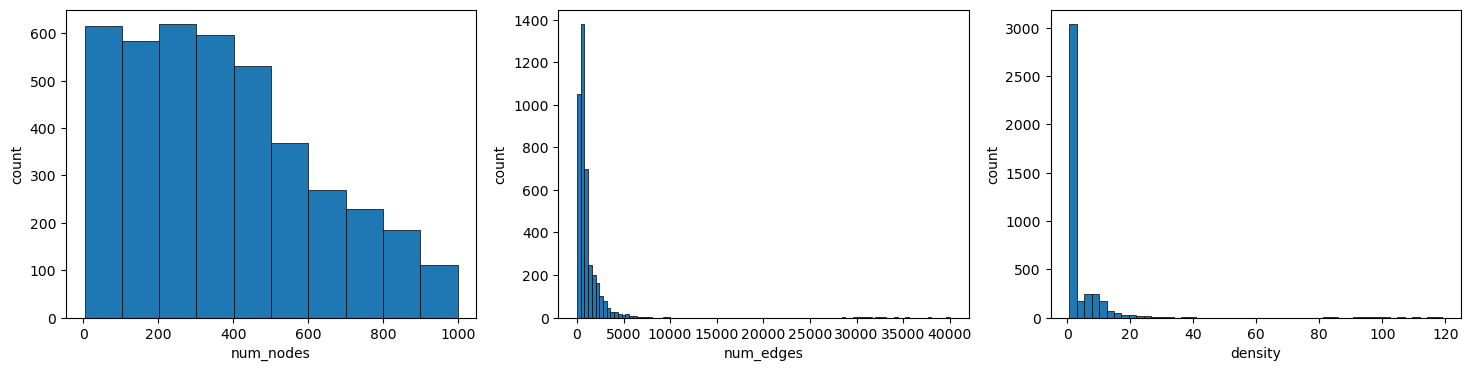

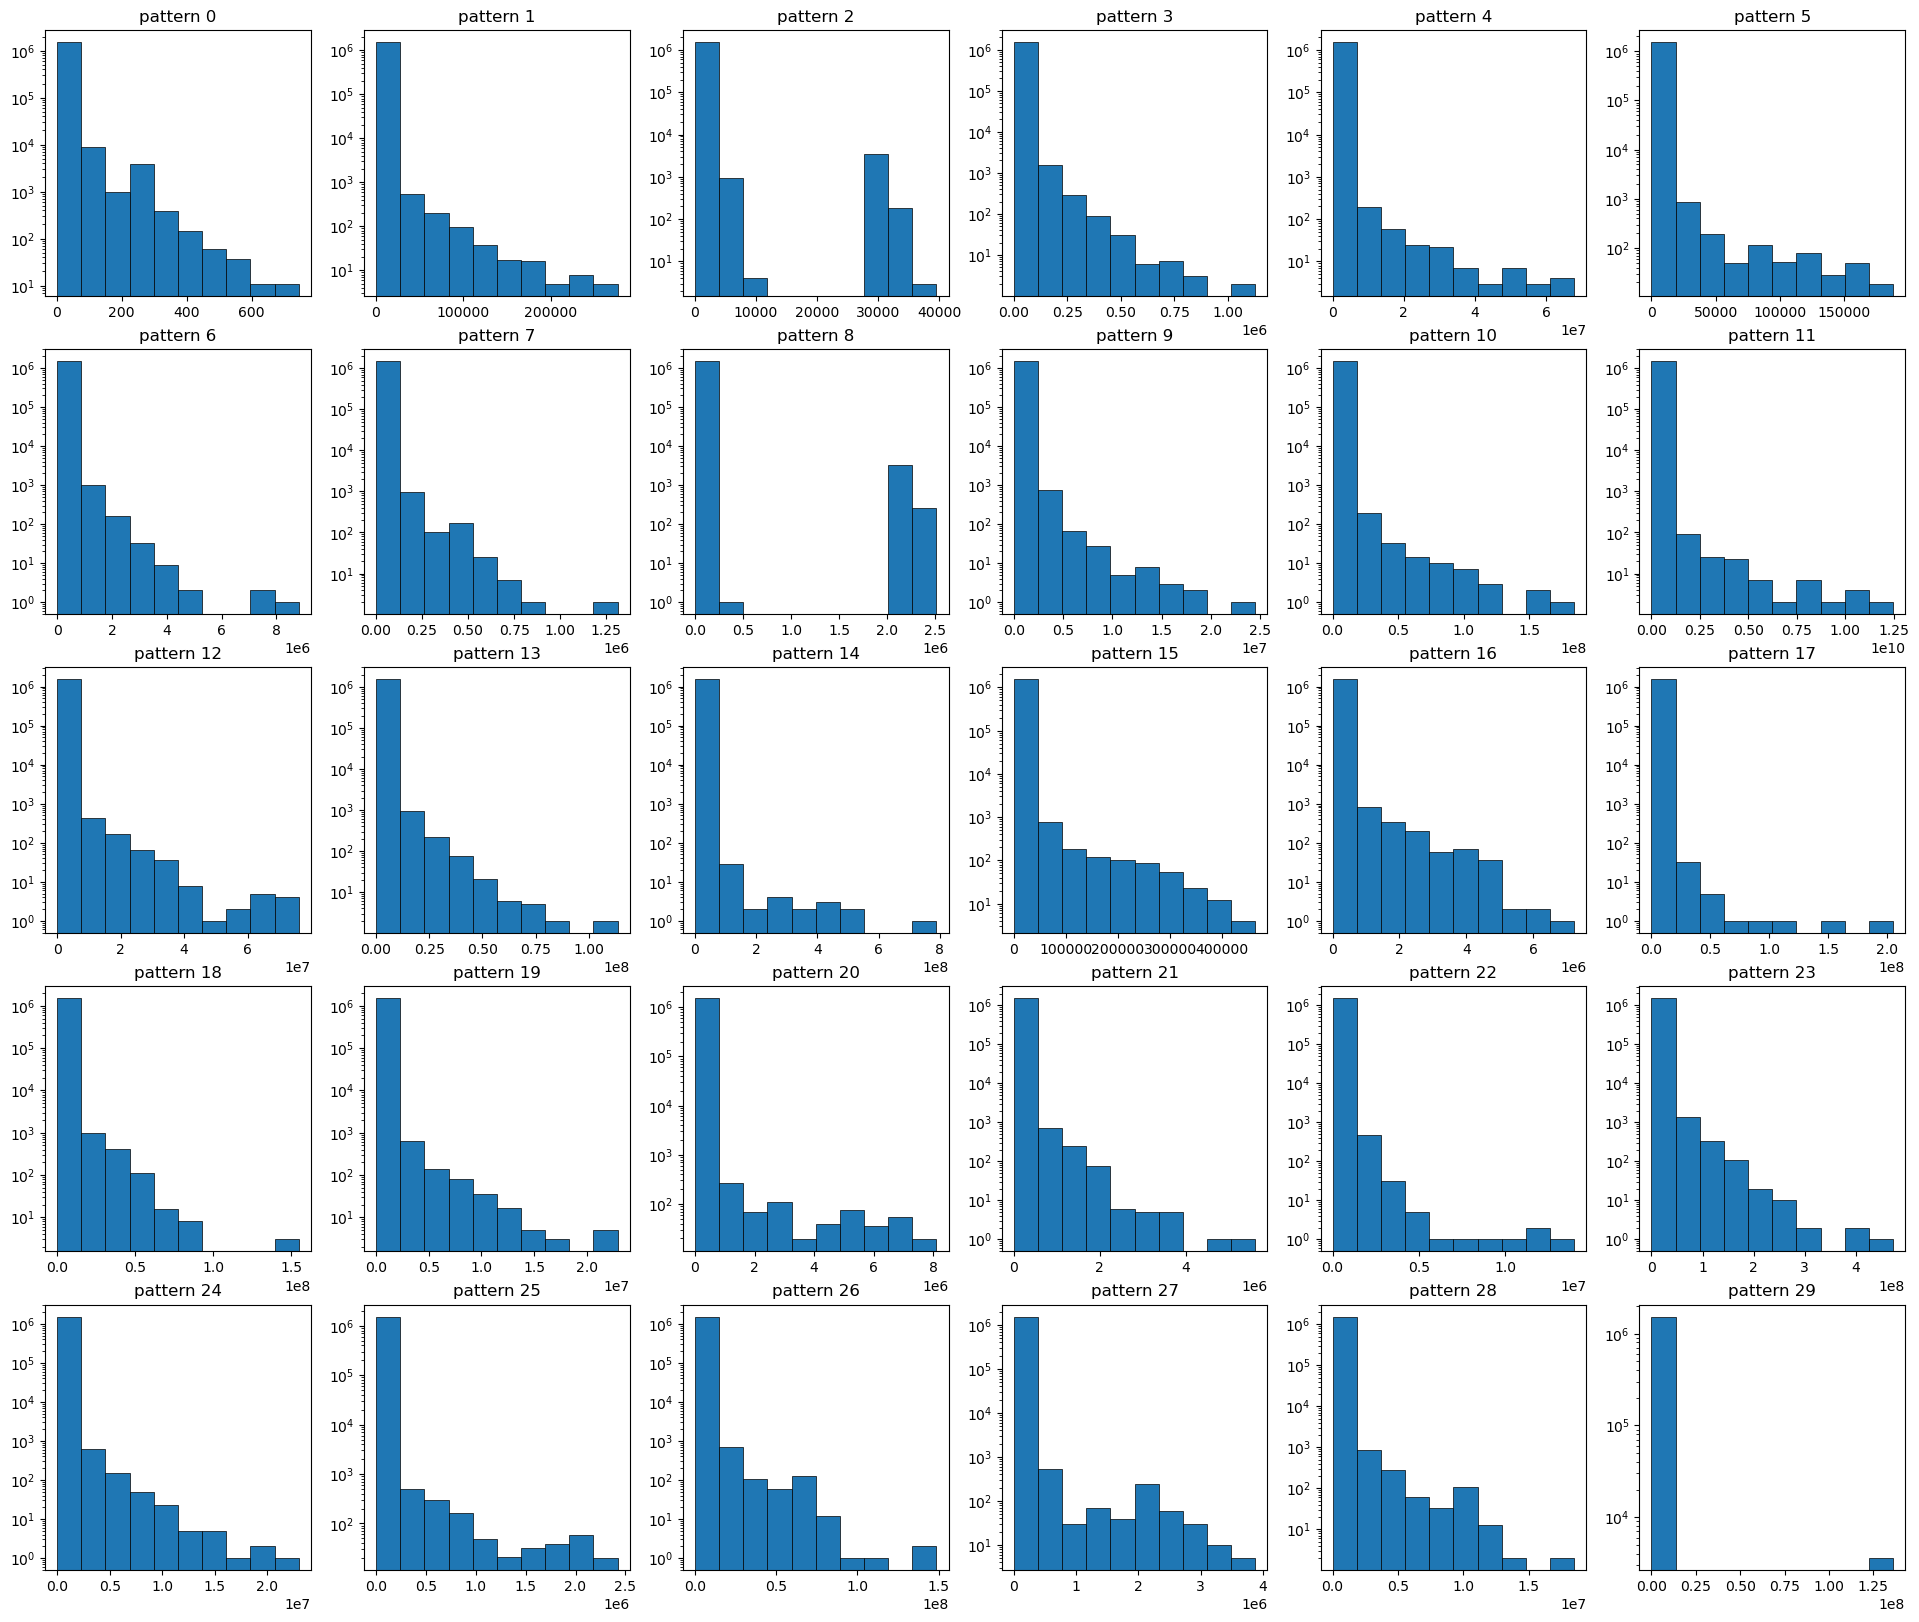

In [5]:
test_dataset = RWDataset('realworld_gt5_test.pt')
test_dataset.visualize_graphs()

# correctness check

In [ ]:
'''
# verify the correctness of the gt_induced_le5 by comparing with the graph match result
for i in range(1550):
    try:
        temp = torch.load(f'../data/temp/realworld_{i}.pt')
    except:
        continue
    tempt = temp.y.T
    tempy = tempt.clone()
    tempy[2] = tempt[3]
    tempy[3] = tempt[2]
    tempy[4] = tempt[5]
    tempy[5] = tempt[4]
    tempy[8] = tempt[10]
    tempy[10] = tempt[8]
    tempy[11] = tempt[12]
    tempy[12] = tempt[13]
    tempy[13] = tempt[11]
    tempy[14] = tempt[15]
    tempy[15] = tempt[14]
    tempy[17] = tempt[18]
    tempy[18] = tempt[17]
    tempy[19] = tempt[20]
    tempy[20] = tempt[19]
    tempy[21] = tempt[22]
    tempy[22] = tempt[21]
    tempy = tempy.T

    if not torch.equal(tempy, rw[i].gt_induced_le5[:, 1:]):
        print(i)
        print(tempy)
        print(rw[i].gt_induced_le5[:, 1:])
'''

In [ ]:
'''
# use cora to verify the correctness of the noninduced_count
with open('../../orca/cora_result', 'r') as f:
    lines = f.readlines()
    lines = torch.tensor([[int(float(x)) for x in line.strip().split()] for line in lines], dtype=torch.int64)
    # multiply the column 1-3 by matrices[3], 4-14 by matrices[4], 15-72 by matrices[5]
    noninduced_3 = torch.mm(size_3, lines[:, 1:4].T).T
    noninduced_4 = torch.mm(size_4, lines[:, 4:15].T).T
    noninduced_5 = torch.mm(size_5, lines[:, 15:].T).T
    noninduced_count = torch.cat([lines[:, :1].clone(), noninduced_3, noninduced_4, noninduced_5], dim=1)

    # read in the noninduced_count from the file '../../orbit-counting/wrappers/out.txt'
    # gtf = open('../../orbit-counting/wrappers/out.txt', 'r').readlines()
    # gtf = torch.tensor([[int(float(x)) for x in line.strip().split()] for line in gtf], dtype=torch.int64)
    # 
    # # compare each line of the noninduced_count with the ground truth
    # for i in range(len(noninduced_count)):
    #     if not torch.equal(noninduced_count[i], gtf[i]):
    #         print(i)
    #         print(noninduced_count[i])
    #         print(gtf[i])

    noninduced_count = torch.tensor([[x[0], x[1]+x[2], x[3], x[4]+x[5], x[6]+x[7], x[8], x[9]+x[10]+x[11], x[12]+x[13], x[14], x[15]+x[16]+x[17], x[18]+x[19]+x[20]+x[21], x[22]+x[23], x[24]+x[25]+x[26], x[27]+x[28]+x[29]+x[30], x[31]+x[32]+x[33], x[34], x[35]+x[36]+x[37]+x[38], x[39]+x[40]+x[41]+x[42], x[43]+x[44], x[45]+x[46]+x[47]+x[48], x[49]+x[50], x[51]+x[52]+x[53], x[54]+x[55], x[56]+x[57]+x[58], x[59]+x[60]+x[61], x[62]+x[63]+x[64], x[65]+x[66]+x[67], x[68]+x[69], x[70]+x[71], x[72]] for x in noninduced_count.tolist()])
    # sum by dimension 0
    noninduced_count = torch.sum(noninduced_count, dim=0).tolist()
    num_nodes = [2] + [3] * 2 + [4] * 6 + [5] * 21
    noninduced_count = [x / y for x, y in zip(noninduced_count, num_nodes)]
    print(noninduced_count)
    # compare with the non-induced count from escape directly
'''

In [ ]:
'''
# draw all the graphs in the pattern graphs
query_graphs_le5 = [nx.graph_atlas(index) for index in [6, 7] + list(range(13, 19)) + list(range(29, 32)) + list(range(34, 39)) + list(range(40, 53))]

# draw all the graphs in query_graphs_le5
fig, axes = plt.subplots(5, 6, figsize=(20, 24))
for i, ax in enumerate(axes.flat):
    nx.draw(query_graphs_le5[i], ax=ax)
'''